# 本次作业的任务是重现第一节课讲解的模型

## 问题1 CMSA网络的搭建

**你需要搭建一个基于LIF或ELIF神经元，拥有突触动力学的神经网络，通过调节一些参数，可以观察到整个网络中bump-wave模式的转变**

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

torch.set_default_dtype(torch.float16)  # 由于LIF神经元相对比较简单，可以使用float16以节省显存
if torch.cuda.is_available():  # 优先使用gpu进行模拟
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'use device:{device}')
torch.set_grad_enabled(False) # 不使用自动梯度
torch.cuda.empty_cache() # 清空显存
dt = 0.5  # 模拟时间步长 ms
__t__ = 0  # 全局时间变量，用于计算不应期

use device:cuda


### Part1 LIF神经元层的搭建

首先我们定义LIF神经元的动力学：
$$
C\frac{dV}{dt}=-g_L*(V-V_{rest})+I_{input}
$$
其中的input包括外界的输入和突触输入。gL是神经元的漏电导。C是膜电容。

神经元的发放由下式定义：
$$
S=H(V-V_{threshold})*H(t-t_{spike}-\tau)
$$
其中的$\tau$是绝对不应期，发放后和在不应期中的膜电位会保持在V_rest

In [ ]:
class LIFlayer:
    def __init__(self, n:int, threshold=-50.0, reset_value=-70.0, membrane_capacitance=1.0, gL=0.05, refractory_period=5):
        self.shape = (n,n)  # 网络形态
        self.threshold = threshold  # 发放阈值
        self.reset_value = reset_value  # 回复和静息电位，单位mV
        self.membrane_capacitance = membrane_capacitance  # 膜电容，单位nF
        self.gL = gL  # 漏电导，单位μS
        self.refractory = refractory_period  # 不应期，单位ms
        self.potential = torch.ones(self.shape).to(device) * (self.reset_value)  # 膜电位，单位mV
        self.spike = torch.zeros(self.shape).to(device)
        self.spike_time = torch.ones(self.shape).to(device) * (-self.refractory*5)  # 上一次的发放时间

    def update(self, input:torch.Tensor):
        assert input.shape == self.shape
        #TODO 请你完成膜电位、神经元发放和不应期的更新
        # 计算电压变化率 dV/dt
        dV_dt = (-self.gL * (self.potential - self.reset_value) + input) / self.membrane_capacitance
        self.potential += dV_dt * dt
        is_refractory = (__t__ - self.spike_time) < self.refractory  # 在不应期内
        is_threshold_crossed = (self.potential >= self.threshold) & ~is_refractory  # 满足发放阈值且不在不应期内
        self.spike = is_threshold_crossed.float()
        self.spike_time[is_threshold_crossed] = __t__
        self.potential[is_threshold_crossed] = self.reset_value
        self.potential[is_refractory] = self.reset_value

        return self.potential, self.spike



### Part2 突触层的搭建

AMPA和GABA统一使用指数衰减型突触（ExpSynapse），在这里模拟了突触电流和电导的过程，以及定义了高斯型波包。

$$
I = g*(V-Vrest)
$$
$$
\tau\frac{dg}{dt}=-g+W*S
$$

Pytorch中并没有自带的周期性边界条件。这里自行定义一个处理周期性边界条件的函数。通过scale_up和scale_down两个函数，实现了由I向E网络的缩放，这样可以在一个架构下处理两个不同尺寸的网络。

此外，请你定义连接权重的高斯波包：

$$
W_{ij}=W^{\lambda}e^{-\frac{(x_i-x_j)^2+(y_i-y_j)^2}{\sigma}}
$$

其中$W^{\lambda}$中${\lambda}$代表兴奋性或抑制性的输出，$\sigma$是衰减因子。

In [ ]:

class Synapseslayer:
    def __init__(self, in_neuron:int, out_neuron:int, m_synapses:int, W=0.02, sigma=18, time_constant=3.0, Vrest = 0.0):
        '''m_synapse must be odd. because in the unfold function, if m is even, the index will shift'''
        self.in_neurons = in_neuron
        self.out_neurons = out_neuron
        assert out_neuron/in_neuron % 1 == 0 or in_neuron/out_neuron % 1 == 0  # 确保E_neurons和I_neurons的数量比是整数，以便于后续进行缩放

        self.shape = (out_neuron, out_neuron, m_synapses, m_synapses)
        self.time_constant = time_constant
        self.weight = self.gaussian(m_synapses, W, sigma)
        self.Vrest = Vrest

        self.i =  torch.zeros(self.shape).to(device)  # 突触电流，单位nA
        self.g = torch.zeros(self.shape).to(device)  # 突触电导，单位μS

    def gaussian(self, n, W, sigma):
        #TODO 请你完成高斯波包函数，返回一个n*n矩阵，其中最大值位于正中间（n为奇数）
        center = n // 2
        X, Y = torch.meshgrid(torch.arange(n)-center, torch.arange(n) - center)
        gaussian = W * torch.exp(-(X**2 + Y**2)/(sigma))
        gaussian = gaussian.to(device)

        return gaussian

    def update(self, input: torch.Tensor, potential:torch.Tensor):
        assert input.shape == (self.in_neurons, self.in_neurons)

        if self.in_neurons<self.out_neurons:
            input = self.scale_up(input,self.out_neurons//self.in_neurons)
        else:
            input = self.scale_down(input,self.in_neurons//self.out_neurons)

        #TODO 请你完成突触电导和电流的更新（提示：使用torch.einsum计算input和weight的逐项乘积，使用repeat将单个神经元的膜电位展开成和突触张量同阶数的张量）
        self.g += (-(self.g / self.time_constant) + torch.einsum('ij,abij->abij', self.weight, input))  * dt
        potential = potential.reshape(self.out_neurons, self.out_neurons, 1, 1)
        potential_expanded = potential.repeat(1, 1, self.weight.shape[0], self.weight.shape[1])
        self.i = torch.einsum('ijkl,ijkl->ijkl', self.g, (self.Vrest - potential_expanded))

        return self.i

    def scale_up(self, input:torch.Tensor, zoom_rate:int):
        a1 = self.shape[3]//2
        a2 = (self.shape[3]-1)//2

        # 以下四个表达式完成了二维矩阵的扩展，以便后面进行平移展开操作
        input = torch.cat((input, input[:,:a1]), dim=1)
        input = torch.cat((input[:,-a1-a2:-a1], input), dim=1)
        input = torch.cat((input, input[:a1,:]), dim=0)
        input = torch.cat((input[-a2-a1:-a1,:], input), dim=0)

        # 平移展开，得到每个突触对应神经元的spike情况
        input = input.unfold(0, self.shape[2], 1).unfold(1, self.shape[3], 1)

        # 将较小的synapselayer的相邻元素重复，得到较大的layer的输入
        input = input.repeat_interleave(zoom_rate,dim=0).repeat_interleave(zoom_rate,dim=1)
        return input

    def scale_down(self, input:torch.Tensor, zoom_rate:int):
        # 和上面的同理
        a1 = self.shape[3]//2
        a2 = (self.shape[3]-1)//2
        input = torch.cat((input, input[:,:a1]), dim=1)
        input = torch.cat((input[:,-a1-a2:-a1], input), dim=1)
        input = torch.cat((input, input[:a1,:]), dim=0)
        input = torch.cat((input[-a2-a1:-a1,:], input), dim=0)

        input = input.unfold(0, self.shape[2], zoom_rate).unfold(1, self.shape[3], zoom_rate)
        return input

### Part3 完成网络构建

将兴奋性神经元层和抑制性神经元层分别组合起来，并完成整个网络的更新

In [ ]:

class Network:
    def __init__(self, En, In, rp, We, Wi, Msynapse) -> None:
        msynapse = Msynapse
        self.E_neurons = LIFlayer(n=En,refractory_period=rp)
        self.synapsesEE = Synapseslayer(En,En,msynapse,W=We)
        self.synapsesEI = Synapseslayer(En,In,msynapse,W=We)

        self.I_neurons = LIFlayer(n=In, refractory_period=rp)
        self.synapsesIE = Synapseslayer(In,En,msynapse,Vrest=-80,sigma=200,W=Wi)
        self.synapsesII = Synapseslayer(In,In,msynapse,Vrest=-80,sigma=200,W=Wi)

    def update(self, inputE:torch.Tensor, inputI:torch.Tensor):
        E_potential, E_spike = self.E_neurons.update(inputE+self.synapsesEE.i.sum(dim=(2,3))+self.synapsesIE.i.sum(dim=(2,3)))
        I_potential, I_spike = self.I_neurons.update(inputI+self.synapsesII.i.sum(dim=(2,3))+self.synapsesEI.i.sum(dim=(2,3)))
        self.synapsesEE.update(E_spike, E_potential)
        self.synapsesEI.update(E_spike, I_potential)
        self.synapsesIE.update(I_spike, E_potential)
        self.synapsesII.update(I_spike, I_potential)

        return E_potential,E_spike

### Part4运行模拟

模拟的更新方式已在上文定义。在模拟时，可以首先进行一段有输入的过程，然后撤去输入，观察网络的自发动力学。

最后输出模拟结束后的图像。最终结果需要看到bump, wave和critical state三种模式。


/raid/yichenx/miniconda3/envs/awqvila/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


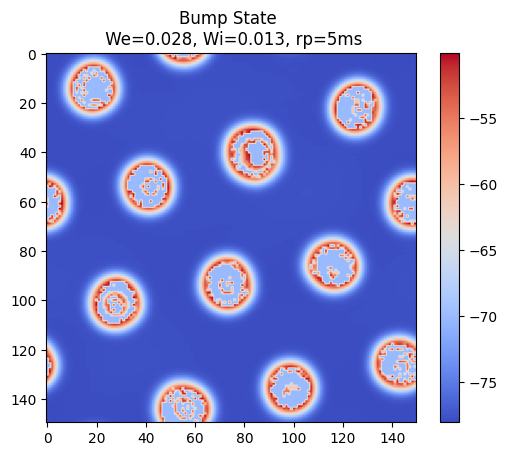

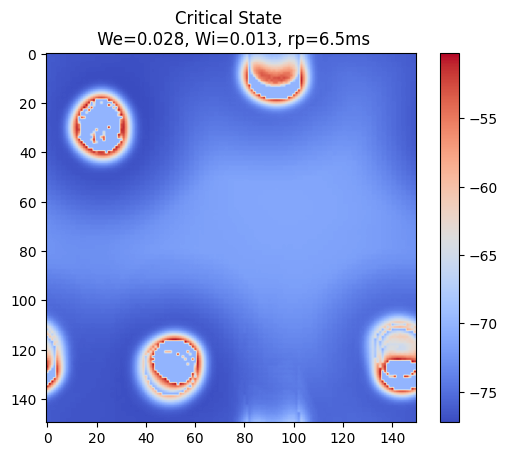

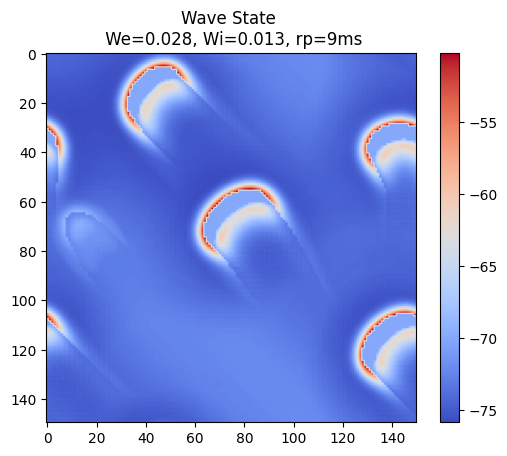

In [ ]:
En = 150   # 兴奋性神经元网格边长数
In = 75   # 抑制性神经元网格边长数，En与In之比需要为整数
runtime1 = 50   # 有外界输入的时间
runtime = 500  # 自发动力学的时间
rp = [5, 6.5, 9] # 不应期时间
We = 0.028  # 兴奋性连接权重
Wi = 0.013   # 抑制性连接权重
msynapse = 75

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
caption = ["Bump State", "Critical State", "Wave State"]

for rt in range(3):
    __t__ = 0
    net = Network(En,In,rp=rp[rt],We=We,Wi=Wi,Msynapse=msynapse)
    voltage_list = []

    for i in range(int(runtime1/dt)):
        __t__+=dt
        E_potential, E_spike= net.update(torch.rand((En,En)).to(device)*5, torch.rand((In,In)).to(device)*5)  # 平均外界输入电流2.5nA
        voltage_list.append(E_potential.clone().cpu())

    for i in range(int(runtime/dt)):
        __t__+=dt
        E_potential, E_spike= net.update(torch.rand((En,En)).to(device)*0, torch.rand((In,In)).to(device)*0)
        voltage_list.append(E_potential.clone().cpu())

    plt.figure(rt)
    plt.imshow(E_potential.cpu(), cmap='coolwarm')
    plt.title(f'{caption[rt]} \n We={We}, Wi={Wi}, rp={rp[rt]}ms')
    plt.colorbar()
    plt.show()


## 问题2 相变过程的探究

在本问题中，需要调整一个参数，模拟出整个相变过程，并通过定义一个序参量绘制相变曲线。序参量可以选择陈国璋老师课上讲过的方式，也可以自行定义。

### Part1 序参量的定义

序参量（Order Parameter）是物理里用于衡量相变系统有序程度的量。一般来说，序参量的变化是由对称性破缺引起的（定义来自Wikipedia）。

在这里，我们可以定义的常见序参量就是Pattern方向的一致性$\Phi$

$$
\Phi=\frac{\left\lvert \sum {\overrightarrow{v_i} }\right\rvert}{\sum {\overrightarrow{\left\lvert  v_i \right\rvert} }}
$$

下面请你完成$\Phi$的定义，并计算示例文件的$\Phi$，并结合不同斑图的状态解释这个序参量的物理含义的解释

In [ ]:
def flood_fill(image, x, y, threshold, visited):
    stack = [(x, y)]
    region = []
    contains_above_threshold = False
    width = image.shape[0]

    while stack:
        px, py = stack.pop()
        if (px, py) not in visited and image[px, py] > threshold:
            visited.add((px, py))
            region.append((px, py))
            if image[px, py] > -55:
                contains_above_threshold = True
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
                nx, ny = (px + dx) % width, (py + dy) % width
                if (nx, ny) not in visited:
                    stack.append((nx, ny))
    if not contains_above_threshold:
        return []

    return region

def calcu_center(image):
    visited = set()
    centers = []

    threshold = -74
    width = image.shape[0]
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if (x, y) not in visited and image[x, y] > threshold:
                region = flood_fill(image, x, y, threshold, visited)
                if region:
                    region_array = np.array(region, dtype=np.float32)
                    x_coords = region_array[:, 0]
                    y_coords = region_array[:, 1]
                    if np.max(x_coords) - np.min(x_coords) > width / 2:
                        x_coords[x_coords < width / 2] += width
                    if np.max(y_coords) - np.min(y_coords) > width / 2:
                        y_coords[y_coords < width / 2] += width

                    x_center = np.mean(x_coords) % width
                    y_center = np.mean(y_coords) % width
                    centers.append([x_center, y_center])

    return centers

def wrap_distance(p1, p2, width):
    dx = min(abs(p1[0] - p2[0]), width - abs(p1[0] - p2[0]))
    dy = min(abs(p1[1] - p2[1]), width - abs(p1[1] - p2[1]))

    return np.sqrt(dx**2 + dy**2)

def compute_velocity(last, current, width):
    dx = current[0] - last[0]
    dy = current[1] - last[1]
    if abs(dx) > width / 2:
        dx = dx - np.sign(dx) * width
    if abs(dy) > width / 2:
        dy = dy - np.sign(dy) * width

    return (dx, dy)

def pair_centers(last_centers, current_centers, width, max_distance=5, margin=2):
    pairs = []
    used_current = set()
    for last in last_centers:
        distances = []
        for i, current in enumerate(current_centers):
            if i not in used_current:
                distance = wrap_distance(last, current, width)
                distances.append((distance, i))
        if not distances:
            continue

        distances.sort()
        best_distance, best_match = distances[0]
        second_best_distance = distances[1][0] if len(distances) > 1 else float('inf')

        if best_distance <= max_distance and (second_best_distance - best_distance) >= margin:
            pairs.append((last, current_centers[best_match]))
            used_current.add(best_match)

    return pairs


def calcu_Phi(data: np.ndarray, max_distance=5, margin=2):
    width = data.shape[1]
    last_center_list = calcu_center(data[0])
    phi_list = []

    for t in range(1, data.shape[0]):
        current_center_list = calcu_center(data[t])
        pairs = pair_centers(last_center_list, current_center_list, width, max_distance=max_distance, margin=margin)
        velocity_list = []

        for last, current in pairs:
            velocity = compute_velocity(last, current, width)
            velocity_list.append(velocity)

        if len(velocity_list) > 0:
            velocities = np.array(velocity_list, dtype=np.float32)
            Phi = np.linalg.norm(velocities.sum(axis=0)) / np.sum(np.linalg.norm(velocities, axis=1))
            phi_list.append(Phi)

        last_center_list = current_center_list

    if len(phi_list) == 0:
        return 0

    average_phi = np.mean(phi_list)
    return average_phi

### Part2 绘制序参量-外部条件的变化曲线

可以选取一个全局参数作为自变量（例如We/Wi、不应期时间等等），自行选择自变量范围和步长，绘制相变曲线，并对你的结果结合课上所学理论给出解释。

也鼓励大家尝试定义其他类型的序参量并进行测试。

In [ ]:
from tqdm import tqdm
rp_range = np.arange(5, 13, 0.5)
torch.manual_seed(0)
np.random.seed(0)

for seed in range(0, 101, 10):
    print("seed =", seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    Phi_list = []
    inputE = torch.randn(int(runtime1/dt),En,En).to(device)*5
    inputI = torch.randn(int(runtime1/dt),In,In).to(device)*5

    __t__ = 0

    for rp in tqdm(rp_range):
        net = Network(En,In,rp=rp,We=We,Wi=Wi,Msynapse=msynapse)
        voltage_list = []

        for i in range(int(runtime1/dt)):
            __t__+=dt
            E_potential, E_spike= net.update(inputE[i], inputI[i])
            # voltage_list.append(E_potential.clone().cpu())

        for i in range(int(runtime/dt)):
            __t__+=dt
            E_potential, E_spike= net.update(torch.rand((En,En)).to(device)*0, torch.rand((In,In)).to(device)*0)
            voltage_list.append(E_potential.clone().cpu())

        voltage_list = voltage_list[-100:]
        Phi = calcu_Phi(np.array([v.numpy() for v in voltage_list]))
        Phi_list.append(Phi)

    np.save(f'Seed={seed}',Phi_list)
    # plot
    plt.figure(seed)
    plt.plot(rp_range, Phi_list)
    plt.xlabel('Refractory Period / ms')
    plt.ylabel('Phi')
    plt.title(f'We={We}, Wi={Wi}')
    plt.savefig(f'Rp-We={We}-Wi={Wi}-Seed={seed}.png')

### Part2-解释
在本问中，相比于作业参考的原文献中对We对相变过程的影响探究，我们选取不应期长度(rp)，探究它对系统的序参量的影响。我们将不同seed得到的结果进行平均得到了最终的图像。

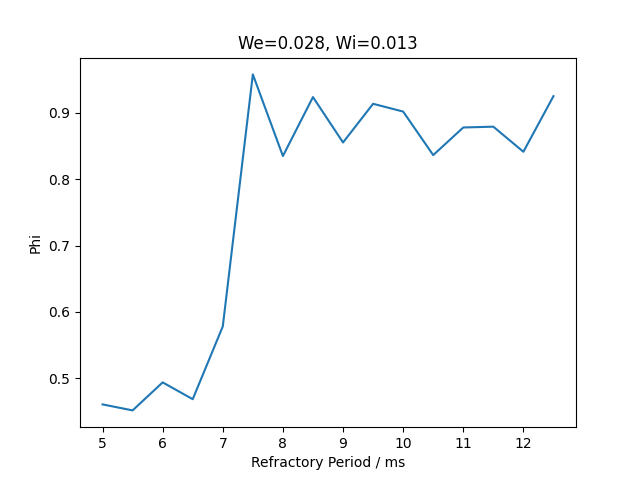



### Part3附加题 临界态对注意力模式的影响

在不同状态下给定一个输入图案，探究Pattern聚焦到图案这一过程的特点。从而解释为什么说大脑应该处于临界态。

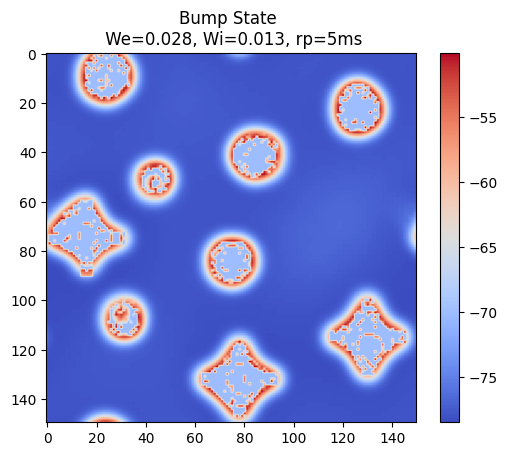

/raid/yichenx/CMSA/ipykernel_3759992/4207423185.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


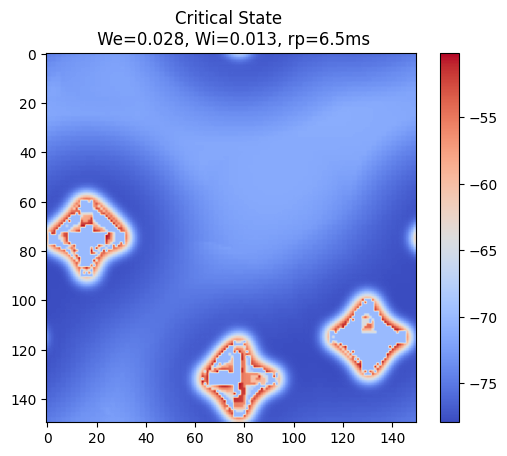

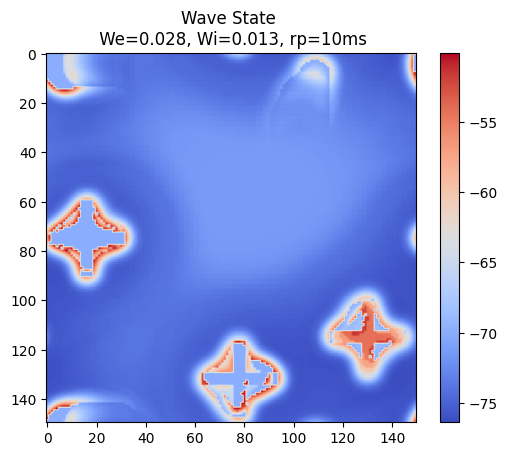

In [ ]:
image = np.load('image_cross.npy')
En = 150 # 兴奋性神经元网格边长数
In = 75 # 抑制性神经元网格边长数，En与In之比需要为整数
runtime1 = 50  # 有外界输入的时间
runtime2 = 300  # 自发动力学的时间
runtime3 = 100  # 有外界输入的时间
rp = [5, 6.5, 10]  # 不应期时间
We =  0.028 # 兴奋性连接权重
Wi =  0.013 # 抑制性连接权重
caption = ["Bump State", "Critical State", "Wave State"]

for rt in range(3):
    __t__ = 0
    net = Network(En,In,rp=rp[rt],We=We,Wi=Wi, Msynapse=75)
    voltage_list = []

    torch.manual_seed(0)
    np.random.seed(0)

    image = torch.tensor(image, dtype=torch.float32)
    input_amp = 5
    image_inputE = image * input_amp

    for i in range(int(runtime1/dt)):
        __t__+=dt
        E_potential, E_spike= net.update(torch.rand((En,En)).to(device)*5, torch.rand((In,In)).to(device)*5)  # 平均外界输入电流2.5nA
        voltage_list.append(E_potential.clone().cpu())

    for i in range(int(runtime2/dt)):
        __t__+=dt
        E_potential, E_spike= net.update(torch.rand((En,En)).to(device)*0, torch.rand((In,In)).to(device)*0)
        voltage_list.append(E_potential.clone().cpu())

    for i in range(int(runtime3/dt)):
        __t__+=dt
        E_potential, E_spike= net.update(image_inputE.to(device), torch.rand((In,In)).to(device)*0)  # 平均外界输入电流2.5nA
        voltage_list.append(E_potential.clone().cpu())

    # V = np.array([v.numpy() for v in voltage_list])
    # np.save(f"rp={rp}.npy", V)
    plt.imshow(E_potential.cpu(), cmap='coolwarm')
    plt.title(f'{caption[rt]} \n We={We}, Wi={Wi}, rp={rp[rt]}ms')
    plt.colorbar()
    plt.show()

## 问题3 更加复杂模型下的动力学性质

**本问题是一个开放性问题，不要求在本次完成。希望学有余力的同学提前思考一下，可以作为最后一次大作业的Discussion**

要求：围绕大脑中的临界态和相变现象研究一个课题，以下给出几个方向可供参考

1.多层动力学网络：考虑多个上述网络的耦合

2.考虑不同种类的抑制性神经元：抑制性神经元（又称中间神经元，interneuron），常见的有PV、SsT、VIP等，可以考虑引入这些神经元观察其对网络动力学特性的影响

3.大脑中其他类型的临界态探究

4.考虑一些学习过程（如LTP等），观察对临界态状态的影响